## Browse through images and try to guess the stage of DR

This kernel allows to browse through randomly selected images one on at a time (of course only in an interactive session).  
First you see the image without label and you can try to 'classify' it.  
Then you'll see the image with label and check if you were correct.  

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join

import numpy as np
from numpy.random import choice
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import ImageDraw, ImageFont, Image

import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display

import torch
from torchvision import transforms
import torchvision

In [2]:
DATA_DIR = '../input/aptos2019-blindness-detection'

train_dir = join(DATA_DIR, 'train_images')
train_df  = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

## Here are a few examples of labeld images

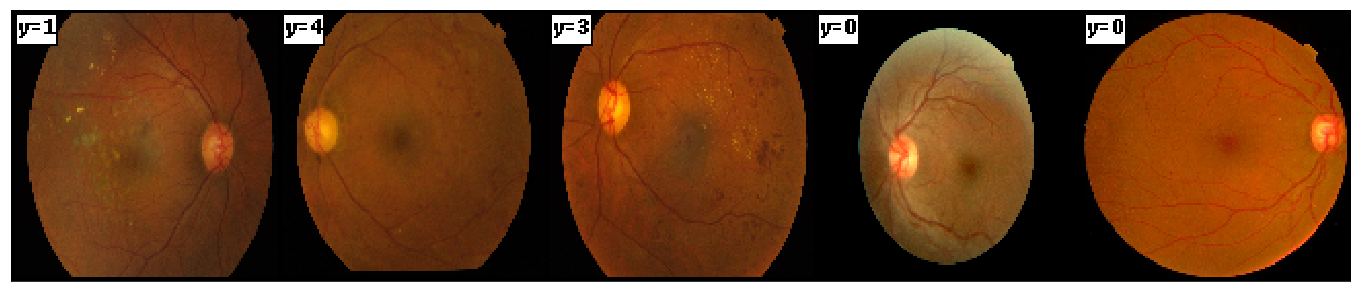

In [3]:
def annotate_image(image: Image,
                   text: str,
                   bounding_box=((0, 0), (20, 15)),
                   fontsize=20):
    
    draw = ImageDraw.Draw(image)
    draw.rectangle(bounding_box, fill='white', outline='black')
    draw.text((2, 1), text, fill='black')
    
    return image


def sample_images(data_dir: str,
                  files=None,
                  resize_to=None,
                  n=15,
                  label_df=None,
                  id_col='id_code',
                  label_col='diagnosis'):
    
    if files is None:
        files = choice(os.listdir(data_dir), size=n)
        
    images = []
    for filename in files:
        img = Image.open(join(train_dir, filename))
        
        if resize_to is not None:
            img = img.resize(resize_to)
        
        if label_df is not None:
            id_   = filename.split('.')[0]
            label = label_df[label_df[id_col] == id_][label_col].item()
            img   = annotate_image(img, f'y={label}')
            
        images.append(img)
        
    return images


def show_grid(*args, n=5, **kwargs):
    
    images = sample_images(*args, n=n, **kwargs)

    tensors = list(map(transforms.ToTensor(), images))
    tensor  = torch.stack(tensors)
    grid    = torchvision.utils.make_grid(tensor, nrow=n // int(np.ceil(n / 5)))
    
    plt.figure(figsize=(24, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([]);
    plt.show()

show_grid(data_dir=train_dir, resize_to=(128, 128), n=5, label_df=train_df)

# Guess diagnosis (interactive)


### Instruction

Just move the slider to the left and start scrolling through the images.

You'll see the unlabled image first.  
Next, will be the same image with the label.  
Etc.

### Stages of diabetic retinopathy

    0 - No DR

    1 - Mild

    2 - Moderate

    3 - Severe

    4 - Proliferative DR
    
    
### random examples per stage

-------------------------------
stage 0:


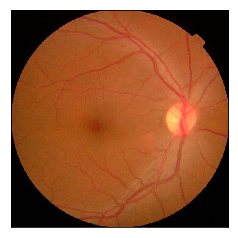

-------------------------------
stage 1:


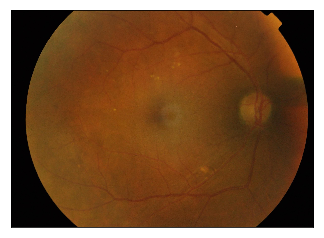

-------------------------------
stage 2:


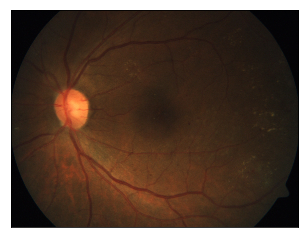

-------------------------------
stage 3:


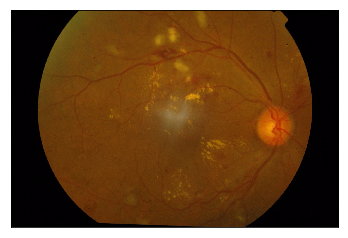

-------------------------------
stage 4:


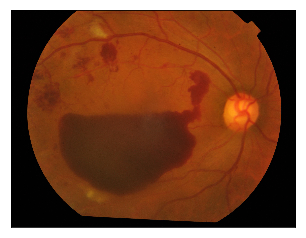

In [4]:
for y, group_df in train_df.groupby('diagnosis'):
    print(f'-------------------------------\nstage {y}:')
    example_id = group_df.sample(1).id_code.item()
    image = Image.open(join(train_dir, f'{example_id}.png'))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()


### class frequency

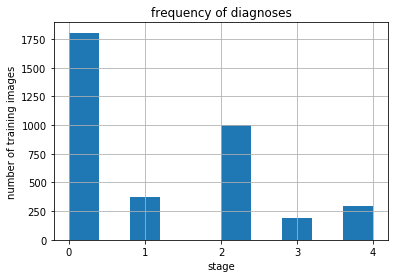

In [5]:
train_df.diagnosis.hist()
plt.xticks(range(5))
plt.title('frequency of diagnoses')
plt.xlabel('stage')
plt.ylabel('number of training images');

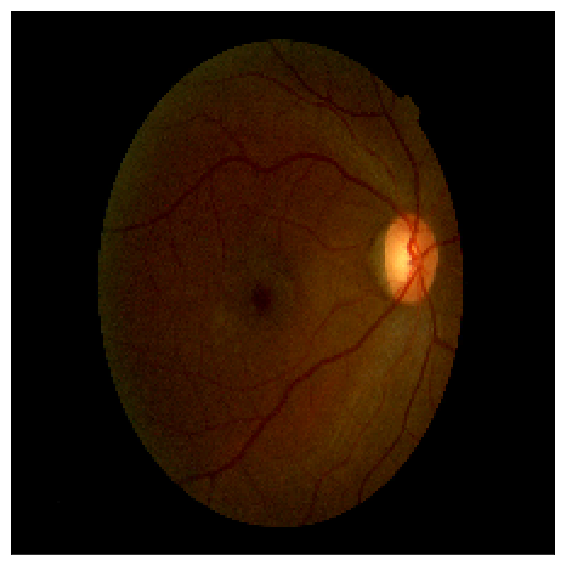

In [6]:
def guess_label(image_dir,
                label_df,
                resize_to=None,
                n=10):
    
    images = []
    
    for _ in range(n):
        file = choice(os.listdir(image_dir))
        
        # raw and labeled version of the same image:
        raw = sample_images(image_dir, files=[file], label_df=None)[0]
        labeled = sample_images(image_dir, files=[file], label_df=label_df, resize_to=resize_to)[0]
        
        images.extend([raw, labeled])  # order: raw, labeld, raw, ....

    def show_image(i):
        
        plt.figure(figsize=(24, 10))
        img = images[i]
        
        if resize_to is not None:
            img = img.resize(resize_to)            
        
        plt.imshow(img)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([]);
        plt.show()    

    return interactive(show_image, i=(0, (n*2)-1))

guess_label(image_dir=train_dir,
            label_df=train_df,
            resize_to=(224, 224),
            n=25)